In [1]:
import pandas as pd
import numpy as np

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

In [3]:
import requests
from multiprocessing.dummy import Pool
from lxml.html import fromstring

def get_page(url):
    html = requests.get(url).text
    dom = fromstring(html)
    dom.make_links_absolute(url)
    return dom

def get_article_urls(url_date):
    pattern = '.b-other_docs__list a'
    dom = get_page(url_date)
    #print([t.attrib['href'] for t in dom.cssselect(pattern)])
    return [t.attrib['href'] for t in dom.cssselect(pattern)]

def get_article_text(url):
    # todo: if 'video' or 'gallery' ... - return ''
    pattern_header = 'h1'
    patterns = ['.article_text_wrapper p', '.b-social__layout-mutation p']
    
    try:
        dom = get_page(url)
    except:
        return None, None
    
    try:
        header = dom.cssselect(pattern_header)[0].text_content().strip()
    except:
        header = ""

    try:
        css_elements = flatten([dom.cssselect(pattern) for pattern in patterns])
        text = "\n\n".join([t.text_content().strip() for t in css_elements])
    except:
        text = ""

    return header, text

flatten = lambda l: [item for sublist in l for item in sublist]

Мы будем собирать данные за годы правления Путина и Медведева

In [4]:
from datetime import timedelta, date

url_date_template = 'https://www.kommersant.ru/archive/news/{}'
url_dates_medved = []

def daterange(start_date, end_date):
    for n in range(0,int ((end_date - start_date).days),10):
        yield start_date + timedelta(n)

start_date = date(2008, 5, 7)
end_date = date(2012, 5, 7)
for single_date in daterange(start_date, end_date):
    url_dates_medved.append(url_date_template.format(single_date.strftime("%Y-%m-%d")))

In [5]:
from datetime import timedelta, date

url_date_template = 'https://www.kommersant.ru/archive/news/{}'
url_dates_putin = []

def daterange(start_date, end_date):
    for n in range(0,int ((end_date - start_date).days),10):
        yield start_date + timedelta(n)

start_date = date(2012, 5, 7)
end_date = date(2016, 5, 7)
for single_date in daterange(start_date, end_date):
    url_dates_putin.append(url_date_template.format(single_date.strftime("%Y-%m-%d")))

In [6]:
pool = Pool(50)

In [7]:
%%time
url_articles_medved = pool.map(get_article_urls, url_dates_medved)
url_articles_medved = flatten(url_articles_medved)

Wall time: 5.14 s


In [8]:
%%time
url_articles_putin = pool.map(get_article_urls, url_dates_putin)
url_articles_putin = flatten(url_articles_putin)

Wall time: 4.57 s


In [9]:
len(url_articles_medved)

4103

In [10]:
len(url_articles_putin)

13429

In [11]:
urls=url_articles_putin+url_articles_medved

In [12]:
df1 = pd.DataFrame({"url": url_articles_putin, "Putin":1})
df2 = pd.DataFrame({"url": url_articles_medved, "Putin":0})

In [13]:
df=pd.concat([df1,df2])

In [14]:
%%time
headers_texts = pool.map(get_article_text, urls)

Wall time: 24min 35s


In [15]:
pool.close()
pool.join()

In [16]:
df["header"] = [t[0] for t in headers_texts]
df["text"] = [t[1] for t in headers_texts]

In [17]:
df=df[df.header.notnull()]

In [18]:
df.to_pickle('komm_archive.pkl')

Лемматизируем слова

In [19]:
import pymorphy2
from nltk.tokenize import word_tokenize
import nltk
#nltk.download('punkt')

In [20]:
class MorphProvider:
    def __init__(self):
        self.cache = {}
        self.morph = pymorphy2.MorphAnalyzer()
    
    def __call__(self, w):
        w = w.lower()
        cached = self.cache.get(w)
        if cached:
            return cached
        try:
            morphed = self.morph.parse(w)[0].normal_form
            self.cache[w] = morphed
            return morphed
        except:
            return None
    
    def morph_string(self, s):
        words = word_tokenize(s)
        return " ".join([self.__call__(w) for w in words])

In [21]:
morph = MorphProvider()

In [22]:
from tqdm import tqdm

In [23]:
df["normalized"] = [morph.morph_string(t) for t in tqdm(df.text)]

100%|███████████████████████████████████| 14563/14563 [00:36<00:00, 401.29it/s]


Убираем цифры

In [24]:
df["normalized_words"] = df.normalized.apply(lambda x: ' '.join([w if w.isalpha() else 'num' for w in x.split() if w.isalpha() or w.isdigit()]))

Векторизуем

In [25]:
from sklearn.feature_extraction.text import CountVectorizer

In [26]:
vectorizer = CountVectorizer(max_features=5000)

In [27]:
%%time
X = vectorizer.fit_transform(df.normalized_words).toarray()

Wall time: 1.34 s


Предсказываем

In [28]:
y = df.Putin

In [29]:
from sklearn.model_selection import train_test_split

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [31]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

In [32]:
depths = np.arange(1,10)
grid = {'max_depth': depths}#, 'max_features': features_num}
gridsearch = GridSearchCV(DecisionTreeClassifier(), grid, scoring='neg_log_loss', cv=5)

In [33]:
gridsearch.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_log_loss', verbose=0)

In [34]:
sorted(gridsearch.grid_scores_, key = lambda x: -x.mean_validation_score)

C:\Users\mrasskazov\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: -0.40091, std: 0.00581, params: {'max_depth': 3},
 mean: -0.40321, std: 0.03017, params: {'max_depth': 4},
 mean: -0.41303, std: 0.03366, params: {'max_depth': 5},
 mean: -0.43027, std: 0.01078, params: {'max_depth': 2},
 mean: -0.44426, std: 0.03984, params: {'max_depth': 6},
 mean: -0.46386, std: 0.00260, params: {'max_depth': 1},
 mean: -0.48593, std: 0.05413, params: {'max_depth': 7},
 mean: -0.57906, std: 0.07664, params: {'max_depth': 8},
 mean: -0.69046, std: 0.06010, params: {'max_depth': 9}]

C:\Users\mrasskazov\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


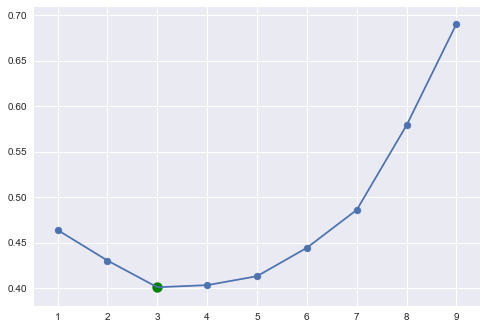

In [35]:
scores = [-x.mean_validation_score for x in gridsearch.grid_scores_]
plt.plot(depths, scores)
plt.scatter(depths, scores)
best_point = np.argmin(scores)
plt.scatter(depths[best_point], scores[best_point], c='g', s=100)

In [44]:
clf_final = DecisionTreeClassifier(max_depth=5)

In [45]:
clf_final.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [46]:
y_pred_proba = clf_final.predict_proba(X_test)
y_pred = clf_final.predict(X_test)

Оцениваем

In [47]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

In [48]:
accuracy_score(y_test, y_pred)

0.80775832475111564

In [49]:
roc_auc_score(y_test,y_pred)

0.68551283836993149

Строим дерево

In [50]:
from sklearn.tree import export_graphviz

def get_tree_dot_view(clf, feature_names=None, class_names=None):
    print(export_graphviz(clf, out_file=None, filled=True, feature_names=feature_names, class_names=class_names))

In [51]:
get_tree_dot_view(clf_final, vectorizer.get_feature_names(), ['putin', 'medvedev'])

digraph Tree {
node [shape=box, style="filled", color="black"] ;
0 [label="читать <= 0.5\ngini = 0.3683\nsamples = 11650\nvalue = [2835, 8815]\nclass = medvedev", fillcolor="#399de5ad"] ;
1 [label="риа <= 0.5\ngini = 0.4472\nsamples = 8380\nvalue = [2829, 5551]\nclass = medvedev", fillcolor="#399de57d"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="интерфакс <= 0.5\ngini = 0.3286\nsamples = 4792\nvalue = [993, 3799]\nclass = medvedev", fillcolor="#399de5bc"] ;
1 -> 2 ;
3 [label="num <= 0.5\ngini = 0.3767\nsamples = 3922\nvalue = [987, 2935]\nclass = medvedev", fillcolor="#399de5a9"] ;
2 -> 3 ;
4 [label="область <= 3.5\ngini = 0.1352\nsamples = 809\nvalue = [59, 750]\nclass = medvedev", fillcolor="#399de5eb"] ;
3 -> 4 ;
5 [label="gini = 0.1293\nsamples = 806\nvalue = [56, 750]\nclass = medvedev", fillcolor="#399de5ec"] ;
4 -> 5 ;
6 [label="gini = 0.0\nsamples = 3\nvalue = [3, 0]\nclass = putin", fillcolor="#e58139ff"] ;
4 -> 6 ;
7 [label="тасс <= 0.5\ngini = 